In [1]:
import matplotlib.pyplot as plt
import torch
cuda = torch.device("cuda:2")

from fitting import create_ensemble, load_data, create_datasets
import torch
labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float, "device":cuda}
base_dir = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction"
save_dir = base_dir + "/mse_scale_1_l_1e9"
quad_strengths, image_data, bins, xx = load_data(base_dir, tkwargs)
xx = xx.cpu()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.to(device=cuda);


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
s = torch.arange(0,2,1).to(device=cuda)
train_dset[s][0][:,0]

tensor([[4.2382],
        [3.3906]])

torch.Size([3, 500, 500])


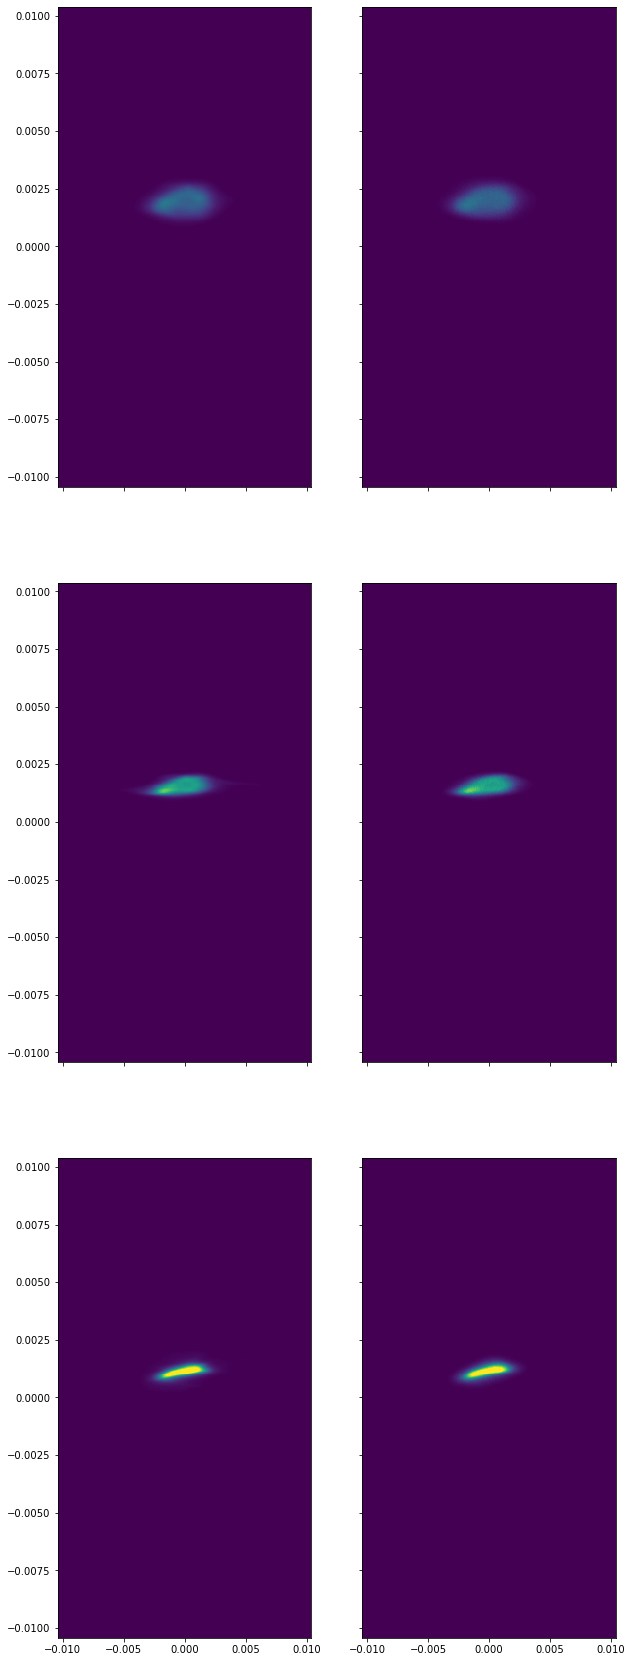

In [3]:
s = torch.arange(0,3,1).to(device=cuda)
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](train_dset[s][0][:,0].to(device=cuda))
print(predictions.shape)
vmax=0.001
fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx.cpu(), train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=vmax
                    )
    ax[i][1].pcolor(*xx.cpu(),predictions[i].cpu().detach(), vmin=0,vmax=vmax)
torch.cuda.empty_cache()


torch.Size([3, 500, 500])


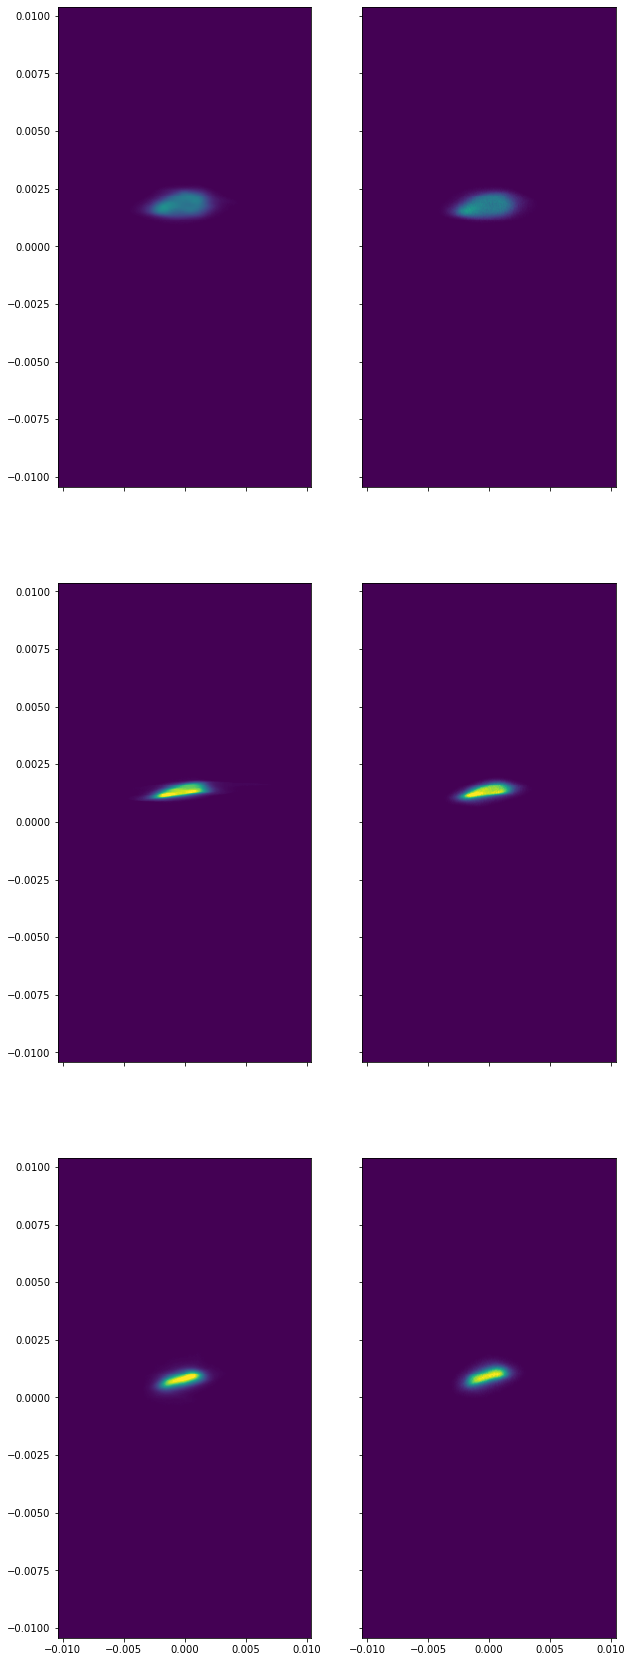

In [4]:
s = torch.arange(0,3,1).to(device=cuda)
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](test_dset[s][0][:,0].to(device=cuda))
print(predictions.shape)
fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx.cpu(), test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=vmax
                    )
    ax[i][1].pcolor(*xx.cpu(),predictions[i].cpu().detach(), vmin=0,vmax=vmax)
torch.cuda.empty_cache()


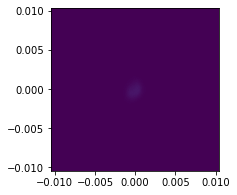

In [5]:
# zero quad strength
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](torch.zeros(1,1).to(device=cuda))

fig,ax = plt.subplots()
fig.set_size_inches(3,3)
ax.pcolor(*xx,predictions[0].cpu().detach(), vmin=0,vmax=0.01)


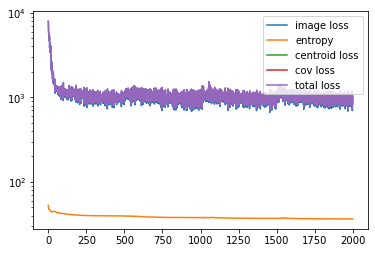

In [6]:
# plot loss record
traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
covs = torch.stack([ele[1] for ele in traces])

plt.semilogy(
    losses, label=["image loss","entropy","centroid loss","cov loss","total loss"]
)
plt.legend()

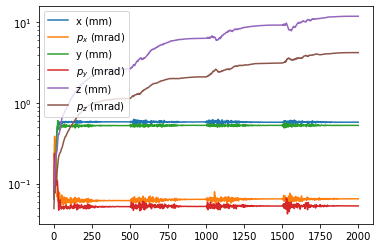

In [7]:
# plot convergence
moments = torch.diagonal(covs, dim1=-2,dim2=-1).sqrt()

plt.semilogy(moments.cpu().detach()*1e3,label=labels)
plt.legend()

In [8]:
initial_beam = ensemble[-1].beam()

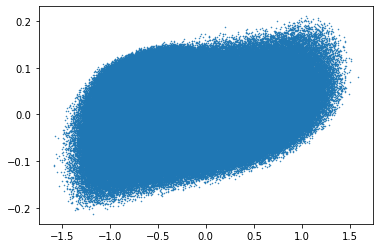

In [9]:
# propagate particles w/quad off
initial_y = initial_beam.y.cpu().detach().numpy()*1e3
initial_py = initial_beam.py.cpu().detach().numpy()*1e3

# distances
dist_to_slits = 3.38 - 2.84 + 0.12/2.0
dist_to_screen = 3.38 + 0.12/2.0

# particles
slits_y = initial_y + initial_py * dist_to_slits
slits_py = initial_py

screen_y = initial_y + initial_py * dist_to_screen
screen_py = initial_py

fig,ax=plt.subplots()
ax.plot(
    initial_y,
    initial_py,
    '.',ms=1
)

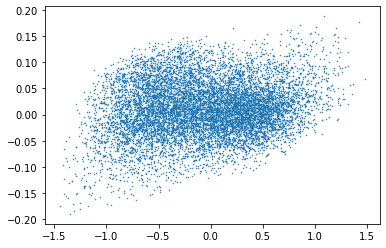

In [10]:
fig,ax=plt.subplots()
ax.plot(
    slits_y[::100], slits_py[::100],
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

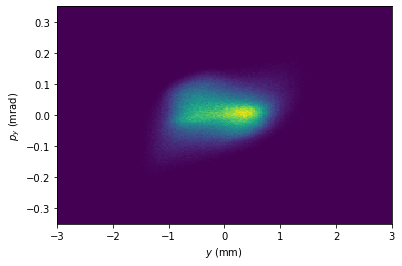

In [11]:
fig,ax=plt.subplots()
import numpy as np
# create a mesh
x = np.linspace(-3,3,200)
y = np.linspace(-0.35,0.35,200)

h, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x,y])
#xc = (xe[:-1] + xe[1:]) / 2
#yc = (ye[:-1] + ye[1:]) / 2
X, Y = np.meshgrid(xe,ye)

ax.pcolor(X, Y, h.T)
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

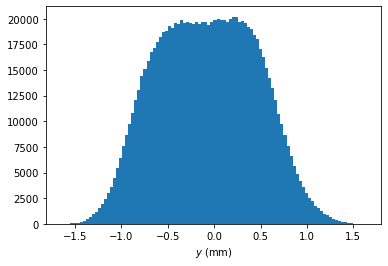

In [12]:
fig,ax=plt.subplots()
ax.hist(
    slits_y, bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

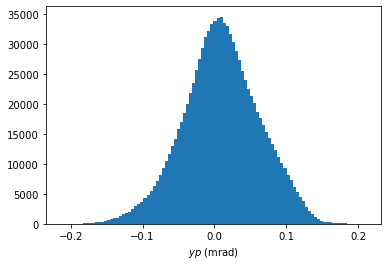

In [13]:
fig,ax=plt.subplots()
ax.hist(
    slits_py, bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [14]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 3.3613e-07,  1.5792e-08,  6.5188e-08, -1.0479e-08,  2.7510e-07,
          3.1321e-07],
        [ 1.5792e-08,  4.2863e-09,  2.0230e-08, -1.3055e-09,  9.3397e-08,
          2.5137e-09],
        [ 6.5188e-08,  2.0230e-08,  2.7918e-07,  3.2891e-09, -3.1633e-07,
         -3.7959e-07],
        [-1.0479e-08, -1.3055e-09,  3.2891e-09,  2.8149e-09,  8.2350e-08,
         -2.5177e-09],
        [ 2.7510e-07,  9.3397e-08, -3.1633e-07,  8.2350e-08,  1.4249e-04,
          3.7131e-06],
        [ 3.1321e-07,  2.5137e-09, -3.7959e-07, -2.5177e-09,  3.7131e-06,
          1.7841e-05]], device='cuda:2', grad_fn=<SqueezeBackward0>)

In [15]:
ycov = cov[2:4,2:4]

In [16]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(cov, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

In [17]:
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 2.783999342170773e-08
beta 10.028194427490234
alpha -0.11814197152853012
gamma 0.10111068189144135


In [18]:
# geometric emittance
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

geo_emit: 2.783999342170773e-08
norm emit: 3.432328185226652e-06


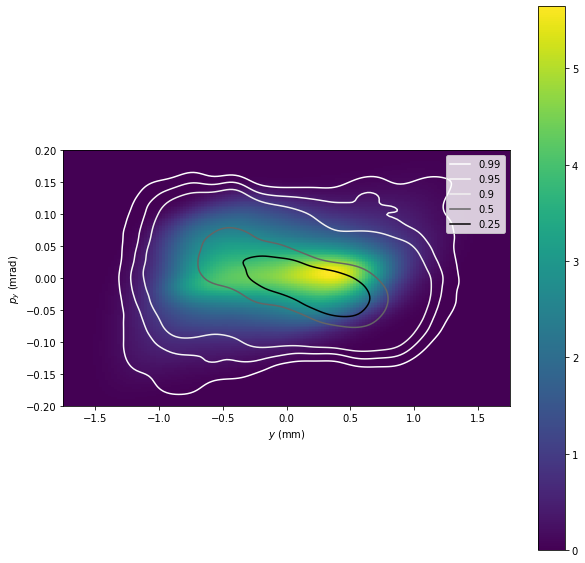

In [19]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib.lines import Line2D

fpath = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction/"

meas_y = np.load(fpath + "y_recon.npy")*1e3
meas_yp = np.load(fpath + "yp_recon.npy")*1e3

fig,ax=plt.subplots()
fig.set_size_inches(10,10)
# create a mesh
x1 = np.linspace(-1.75,1.75,150)
x2 = np.linspace(-0.2,0.2,150)

h_reconstruction, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x1,x2], density=True)
h_slitscan, _, _ = np.histogram2d(meas_y, meas_yp, bins=[x1,x2], density=True)

# apply median filter
h_reconstruction = gaussian_filter(h_reconstruction, 3)
h_slitscan = gaussian_filter(h_slitscan,3)

# get cdf of densities
vmax = h_slitscan.max()
test_levels = np.linspace(0, vmax, 1000)
# for each level calculate the fractional sum
total = h_slitscan.sum()

sums = []
for ele in test_levels:
    sums += [np.where(h_slitscan >= ele, h_slitscan, 0.0).sum() / total]
sums = np.array(sums)

# calculate levels
quantiles = [0.25, 0.5,0.9,0.95, 0.99]
levels = []
for ele in quantiles[::-1]:
    diff = sums - ele
    levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
clevels = np.array(levels).flatten()
x1c = (xe[:-1] + xe[1:]) / 2
x2c = (ye[:-1] + ye[1:]) / 2

X, Y = np.meshgrid(xe,ye)
Xc, Yc = np.meshgrid(x1c,x2c)

c1 = ax.pcolor(X, Y, h_reconstruction.T)
#ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
c2 = ax.contour(Xc, Yc, h_slitscan.T, levels=clevels,cmap="Greys")

custom_lines = []
for j in range(len(clevels)):
    lc = c2.collections[j].get_edgecolor()
    custom_lines += [Line2D([0],[0], color=lc)]
ax.legend(custom_lines, quantiles[::-1])

cbar = fig.colorbar(c1)
# add ellipse
#ax.add_patch(confidence_ellipse(ycov.cpu().detach().numpy(),1.0e3,edgecolor='red'))

ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")
ax.set_aspect(5)
#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)

In [20]:
# do core analysis
initial_data = initial_beam.data[:,2:4].cpu()

# sort by distance from origin in 4D phase space
initial_norm = torch.norm(initial_data, dim=-1)
initial_data_sorted = initial_data[torch.argsort(initial_norm),:]


geo_emit: 2.312943969684511e-08
norm emit: 2.8515748908830574e-06
beta 8.786886215209961
alpha -0.012807866558432579
gamma 0.11382463574409485


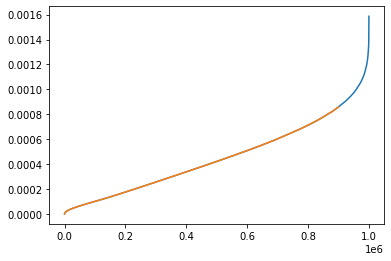

In [21]:
# get cov/emit of 95%
frac = 0.90
partial = initial_data_sorted[:int(initial_data_sorted.shape[0]*frac)]
cov = torch.cov(partial.T)

plt.plot(torch.norm(initial_data_sorted, dim=-1).detach().numpy())
plt.plot(torch.norm(partial, dim=-1).detach().numpy())

emit = torch.det(cov).sqrt()
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

twiss = cov / emit
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")